# Partial-fix benchmark selection

In [1]:
import json
import os
import pandas as pd
from pathlib import Path
from datetime import datetime
from matplotlib import pyplot as plt

# path to benchmark folder
benchmark_path = Path('../benchmarks/')

def find_bad_repositories(history):
    with open(history) as json_file:
        data = json.load(json_file)
        print("\n".join(data["skipped"]))

        
def value_score(score):
    keywords = score["contains_keywords"]
    fix_size = int(score["fix_size"])
    labels = score["has_labels"]
    final_commit_size = int(score["intersecting"]["final_commit_size"])
    intersecting_score = float(score["intersecting"]["computed_score"])
    final_commit_size = int(score["intersecting"]["intersection_size"])
    previous_commit_size = int(score["intersecting"]["previous_commits_size"])
    has_makefile = score["is_makefile_based"]
    new_files = score["no_new_files"]
    has_new_files = bool(new_files)
    no_other_files = score["no_other_files"]
    reopened = score["reopen"]
    status = score["status"]
    prohibited_files = score["num_prohibited_files"]
    total_changes = int(score["total_changes"])
    score_dict = dict()
    score_dict["keywords"] = 15*len(keywords)
    score_dict["labels"] = 15*len(labels)
    score_dict["intersecting_score"] = intersecting_score * 150
    score_dict["no_other_files"] = 50 / (1.0 + prohibited_files)
    #score_dict["makefile"] = has_makefile * 10
    score_dict["no_new_file"] = 50.0 / (1.0 + len(new_files))
    score_dict["reopened_or_status"] = (reopened + status) * 50
    score_dict["changes"] = 150.0 / total_changes
    return score_dict, sum(score_dict.values())
        
        
def get_issue_data_frame(repository: str, repo_url: str) -> pd.DataFrame:
    '''
    Convert each info.json of a repository to a dataframe friendly format
    :param repository: name of repository
    :param repo_url: url of repository
    :return: dataframe with all repositories
    '''
    issues_path = Path(repository)
    issue_directories = [x for x in issues_path.iterdir() if x.is_dir()]
    issue_json_list = list()
    for issue_dir in issue_directories:
        issue_json = issue_dir.joinpath('info.json')
        if issue_json.exists():
            with open(issue_json) as json_file:
                data = json.load(json_file)
                
                # time
                first_commit = datetime.strptime(data["first_commit"], "%Y-%m-%d %H:%M:%S")
                last_commit = datetime.strptime(data["last_commit"], "%Y-%m-%d %H:%M:%S")
                data["closed_after_minutes"] = int((last_commit - first_commit).total_seconds() / 60)
                
                # extract porperties
                score_details = data["score"]
                data["partial_fix_size"] = data["score"]["intersecting"]["previous_commits_size"]
                data["final_fix_size"] = data["score"]["intersecting"]["final_commit_size"]
                score_dict, points = value_score(data["score"])
                data = {**data, **score_details, "score": points}
                
                # summarize commit and file statistic for better usage in the dataframe
                commits = data["commits"]
                total_files = sum([len(commit["files"]) for commit in commits])
                total_deletions = sum([commit["diff_deletions"] for commit in commits])
                total_additions = sum([commit["diff_additions"] for commit in commits])
                total_size = sum([commit["diff_file_size"] for commit in commits])
                total_changes_not_parent = sum([commit["diff_file_size"] for commit in commits if not commit["is_parent"]])
                data["commits"] = len(commits)
                data["files"] = total_files
                data["additions"] = total_additions
                data["deletions"] = total_deletions
                data["file_size"] = total_size
                data["total_changes_plain"] = total_changes_not_parent
                data["repository"] = repo_url
                data["issue_path"] = issue_dir
                data["url"] = f"{repo_url}/issues/{data['number']}"
            
                issue_json_list.append(data)
    df = pd.DataFrame(issue_json_list)
    return df


def number_searched_repos():
    '''
    Count all visited repositories
    '''
    global test
    history_file = benchmark_path.joinpath('history/history.json')
    with open(history_file) as json_file:
        data = json.load(json_file)
        return len(data["skipped"]), len(data["interesting"])
    return 0, 0

def count_searched_issues():
    history_dir = benchmark_path.joinpath('history')
    sum = 0
    for filename in os.listdir(history_dir):
        if not filename.endswith("history.json"):
            with open(str(history_dir) + "/" + filename) as json_file:
                data = json.load(json_file)
                sum += len(data["covered_issues"])
    return sum


# create the dataframe for all repos and a map of url -> issue_dataframe
repository_directories = [x for x in benchmark_path.iterdir() if x.is_dir()]
repos_json_list = list()
issues = pd.DataFrame()
for repo_dir in repository_directories:
    repo_json = repo_dir.joinpath('repository.json')
    if repo_json.exists():
        with open(repo_json) as json_file:
            # if an issue is present here it matches the criterias
            # modify the dataframe for better analysis
            data = json.load(json_file)
            data["issues"] = os.fspath(repo_dir)
            
            # skip empty directories
            repo_issue = get_issue_data_frame(data["issues"], data["url"])
            if repo_issue.empty:
                continue
            
            data["name"] = data["url"].replace("https://github.com/", "")
            data["ratio_in_%"] = data["ratio"] * 100
            del(data["ratio"])
            repos_json_list.append(data)
            
            # merge all issues to one dataframe
            data["mean_score"] = repo_issue["score"].mean()
            data["median_score"] = repo_issue["score"].median()
            data["max_score"] = repo_issue["score"].max()
            data["repo_score"] = repo_issue["score"].sum()
            # Alternative for repo_score: a good repo has a good mean_score but also many interesting issues
            # data["repo_score"] = data["mean_score"] * data["ratio_in_%"])
            
            issues = pd.concat([issues, repo_issue])
            
# find_bad_repositories(benchmark_path.joinpath("history/history.json"))            
issues = issues[issues["file_size"] > 0]
repositories = pd.DataFrame(repos_json_list).sort_values('repo_score', ascending=False)
repositories = repositories[["name", "url", "repo_score", "mean_score", "median_score", "max_score", "size", "all_issues", "interesting_issues", "ratio_in_%"]]

name  \
226                radareorg/radare2   
180  jerryscript-project/jerryscript   
201                  rsyslog/rsyslog   
266        zephyrproject-rtos/zephyr   
8                      openwall/john   
202                            i3/i3   
125              DynamoRIO/dynamorio   
44                       openzfs/zfs   
131                greenplum-db/gpdb   
126                  openssl/openssl   
97                         curl/curl   
134                      swaywm/sway   
14                     open-mpi/ompi   
91                       fwupd/fwupd   
12                 OpenSIPS/opensips   
118                      nanomsg/nng   
171              open62541/open62541   
176                gluster/glusterfs   
249       varnishcache/varnish-cache   
132                  neomutt/neomutt   

                                                   url    repo_score  \
226               https://github.com/radareorg/radare2  31045.413477   
180  https://github.com/jerryscript-project/jerrysc...  26409.099715   
201                 https://github.com/rsyslog/rsyslog  22408.409153   
266       https://github.com/zephyrproject-rtos/zephyr  19890.635714   
8                     https://github.com/openwall/john  18709.040687   
202                           https://github.com/i3/i3  17265.592296   
125             https://github.com/DynamoRIO/dynamorio  16360.973366   
44                      https://github.com/openzfs/zfs  16002.185600   
131               https://github.com/greenplum-db/gpdb  15140.275012   
126                 https://github.com/openssl/openssl  14600.643630   
97                        https://github.com/curl/curl  13208.276853   
134                     https://github.com/swaywm/sway  10535.456564   
14                    https://github.com/open-mpi/ompi   9968.483014   
91                      https://github.com/fwupd/fwupd   9134.049544   
12                https://github.com/OpenSIPS/opensips   8770.350891   
118                     https://github.com/nanomsg/nng   8496.766070   
171             https://github.com/open62541/open62541   8359.956812   
176               https://github.com/gluster/glusterfs   7971.295330   
249      https://github.com/varnishcache/varnish-cache   7505.193425   
132                 https://github.com/neomutt/neomutt   7192.815367   

     mean_score  median_score   max_score    size  all_issues  \
226  242.542293    265.347935  356.923196  132266       18081   
180  275.094789    280.143633  362.307830   58877        4627   
201  287.287297    295.563387  375.116427   63503        4558   
266  288.270083    290.299914  380.000059  385248       33556   
8    230.975811    235.630321  378.571583  118508        4640   
202  274.057021    281.145122  367.202270   12830        4316   
125  255.640209    276.928295  360.201188   78960        4803   
44   266.703093    294.655543  345.422609   90846       11599   
131  256.614831    269.166861  345.697756  578314       11696   
126  239.354814    257.500196  364.166814  229027       14635   
97   258.985821    280.162972  329.838836   75503        6695   
134  263.386414    273.086326  395.555682   28849        6096   
14   262.328500    280.124130  341.562560  145017        8701   
91   285.439048    288.401039  378.000096   21187        2953   
12   257.951497    254.775835  375.231936  140676        2442   
118  274.089228    280.234212  325.050204   11850        1437   
171  253.332025    280.742728  375.013743   35317        4279   
176  234.449863    259.326407  325.164519  167773        2284   
249  258.799773    281.631702  325.811713   30381        3559   
132  266.400569    268.846883  311.128410  114633        2759   

     interesting_issues  ratio_in_%  
226                 129    0.713456  
180                  96    2.074778  
201                  78    1.711277  
266                  69    0.205626  
8                    81    1.745690  
202                  63    1.459685  
125                  64    1.332501  
44      

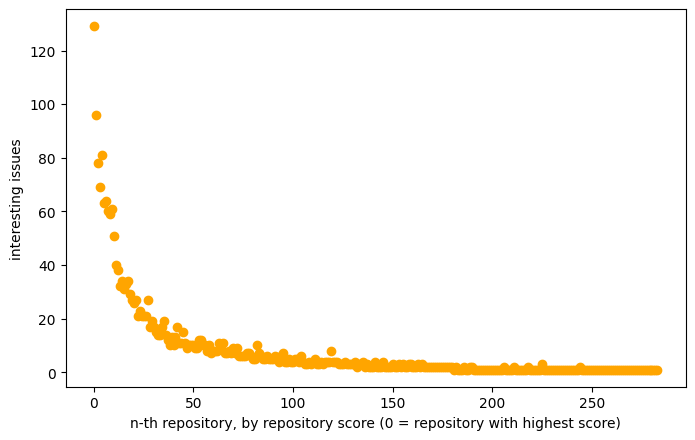

In [2]:
#repositories.head(15)
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100
plt.xlabel('n-th repository, by repository score (0 = repository with highest score)')
plt.ylabel('interesting issues')
interesting_issue_increase = [sum(repositories.interesting_issues[:idx]) for idx in range(len(repositories.interesting_issues))]
#plt.plot(range(len(repositories)), interesting_issue_increase, marker='o', linestyle='')
plt.plot(range(len(repositories)), repositories['interesting_issues'], marker='o', linestyle='', color="orange", linewidth=3)
plt.savefig("distribution.png")

repositories.head(20)

Available columns: commits, first_commit, last_commit, number, score, closed_after_minutes, partial_fix_size, final_fix_size, all_labels, contains_keywords, fix_size, has_labels, intersecting, is_makefile_based, no_new_files, no_other_files, num_prohibited_files, prohibited_files, reopen, status, strategy, total_changes, files, additions, deletions, file_size, total_changes_plain, repository, issue_path, url
len 1742 2159


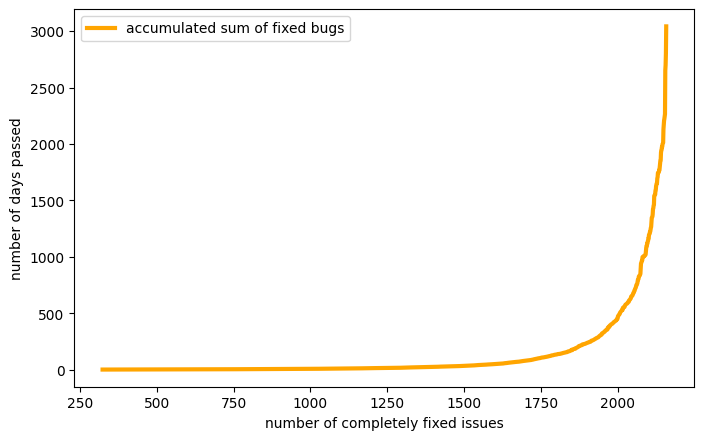

In [3]:
from collections import Counter
import numpy as np

print(f"Available columns: {', '.join(issues.columns)}")
sorted_issues = issues.sort_values('closed_after_minutes', ascending=True)[["total_changes", "closed_after_minutes", "url", "commits", "first_commit", "score", "status", "reopen", "all_labels", "contains_keywords", "intersecting", "is_makefile_based", "no_other_files", "additions", "deletions"]]

plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100
print("len", len(sorted_issues[sorted_issues["closed_after_minutes"] <= 100 * 24 * 60]), len(sorted_issues))

minutes = [int(x/(60*24)) + 1 for x in sorted_issues['closed_after_minutes'] if x >= 0]
count = Counter(minutes)
count_dict = dict(count)
keys = list(count_dict.keys())
values = []
val = 0
for x in keys:
    val += count_dict[x]
    values.append(val)

plt.xlabel('number of completely fixed issues')
plt.ylabel('number of days passed')
plt.plot(values, keys, marker='', linestyle='-', color="orange", linewidth=3, label="accumulated sum of fixed bugs")
plt.legend(loc="upper left")
plt.savefig("fixed-over-time.png")

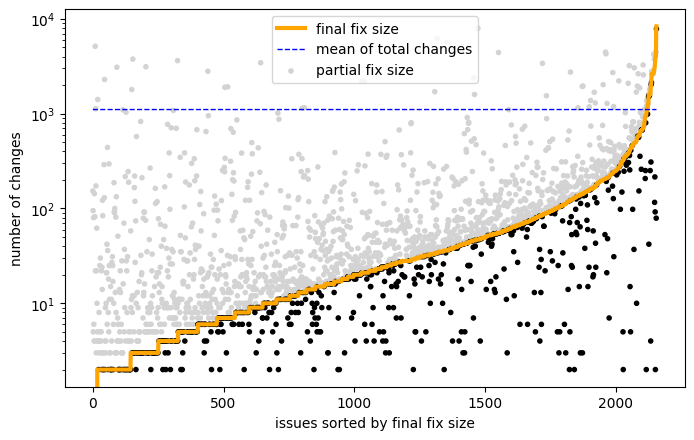

In [4]:
# plot partial fix <-> fix
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

issues_fix_size = issues.sort_values("final_fix_size")
issues_fix_size = issues_fix_size[issues_fix_size["partial_fix_size"] < 10000]

colors = []
for index, row in issues_fix_size.iterrows():
    colors.append("lightgray" if row["partial_fix_size"] > row["final_fix_size"] else "black")
plt.scatter(range(len(issues_fix_size)), issues_fix_size["partial_fix_size"], marker=".", c=colors, label="partial fix size")
plt.plot(range(len(issues_fix_size)), issues_fix_size["final_fix_size"], marker=" ", linestyle="-", linewidth=3, color="orange", label="final fix size")
plt.plot(range(len(issues_fix_size)), [issues_fix_size["total_changes"].mean()] * len(issues_fix_size), marker=" ", linestyle="--", linewidth=1, color="blue", label="mean of total changes")
plt.xlabel('issues sorted by final fix size')
plt.ylabel('number of changes')
plt.legend(loc="upper center")
plt.yscale("log")
plt.savefig("fix-partial-fix-correlation.png")

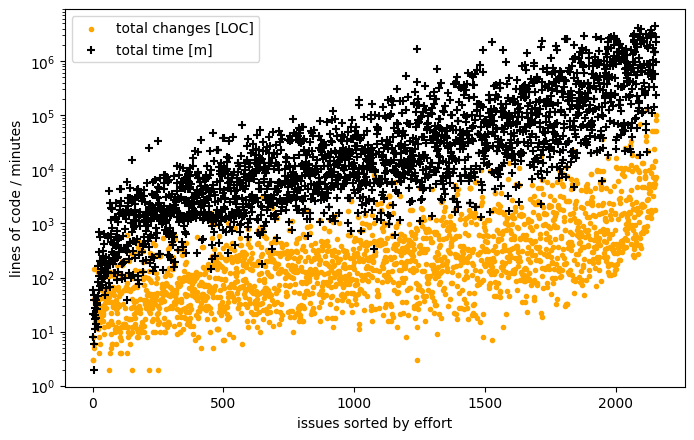

In [5]:
# plot effort 
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

# prepare data
issues_duration = issues.copy()
issues_duration = issues_duration[issues_duration["closed_after_minutes"] > 0]
issues_duration["speed"] = issues_duration["total_changes"]/issues_duration["closed_after_minutes"]
issues_duration["repo_size"] = issues_duration.apply(lambda row: repositories[repositories["url"] == row["repository"]]["size"].min() / 1024, axis=1)
issues_duration = issues_duration.sort_values("file_size", ascending=True)

df = issues_duration["total_changes"] * issues_duration["closed_after_minutes"]
issues_duration["normalized_effort"]=100 * df/df.max()
issues_duration=issues_duration.sort_values("normalized_effort")

plt.scatter(range(1, len(issues_duration) + 1), issues_duration["total_changes"], marker=".", c="orange", label="total changes [LOC]")
plt.scatter(range(1, len(issues_duration) + 1), issues_duration["closed_after_minutes"], marker="+", c="black", label="total time [m]")
# print(issues_duration["total_changes"].min(), issues_duration["total_changes"].max(), issues_duration["closed_after_minutes"].min(), issues_duration["closed_after_minutes"].max())

plt.yscale("log")
plt.xlabel('issues sorted by effort')
plt.ylabel('lines of code / minutes')
plt.legend(loc="upper left")
plt.savefig("effort.png")

## Criteria for partial fixes

**Bold criteria** are already considered.  
*Italic criteria* are partially considered.

Benchmark tasks for partial fixes should fulfill the following criteria:

- **C programming language**
- **Real-world programs (or parts of it)**
- **Makefile-based projects (for Angelix)**
- *Executable test cases available that expose defect and demonstrate fix*
    - we check for CI tests
- LLVM bitcode can be generated (for Klee)
- Language constructs supported by [Angelix](http://angelix.io/) and [Klee](https://klee.github.io/)

Criteria on recurring fix:
- **Recurring fixes modify same code lines* or code lines that reach each other according to control-flow
- Recurring fixes in a single method

Criteria on defects in programs:

- Defect statements are only over primitive data types: int, long, char, enum, struct, integer arrays, pointers
- Defect classes: defects are allowed in conditions and/or assignments
- Multiple defect statements are allowed, but no chunks of code that constitute a single defect together

## Repository selection

We only consider repositories that fulfill the following requirements:

* C-language projects, according to GitHub

We ignore some repositories explicitly. These are listed in file [../config/denylist.txt](../config/denylist.txt).

Repositories are selected based on their number of stars - most stars first.  
We considered the **1448** (1024 before) most-starred C repositories. **288** (117 before) fulfill the requirements.

## Issue selection

We consider an issue a partial fix if it fulfills the following criteria:

1. Modifies at least one `.c`-file
2. Fulfills one of the following two:
    * Commit related to issue -> issue closed -> issue reopened -> Commit related to issue -> issue closed again
    * A commit fails the CI, and a later commit fixes the CI
   
With these criteria, we extract candidate partial fixes $(h_{original}, h_{fix1}, h_{fix2})$.

There's no age limit on issues.

In [6]:
# import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown


def markdown_link(name, link):
    if isinstance(link, str):
        return f"[{name}]({link})"
    if not link:
        return 'None'
    if len(link) == 1:
        return markdown_link(name, link[0])
    return ", ".join([markdown_link(f"{name}{idx}", li) for idx, li in enumerate(link)])


def get_commit_files_markdown(issue_url):
    commits = partial_fix_to_commit_hashes(issue_url)
    originals, intermediates, final_fix = commits['original'], commits['fixes'][:-1], commits['fixes'][-1]
    return f"{markdown_link('original', originals)}, {markdown_link('interim', intermediates)}, {markdown_link('fix', final_fix)}"


def print_stats():
    '''
    Print some statistics.
    Count repositories, issues and state how often interesting issues occur.
    '''
    print("Stats:")
    skipped, interesting = number_searched_repos()
    skipped += 8
    number_all_repos = skipped + interesting
    number_processed_issues = count_searched_issues()
    print(f"  1) Checked {number_all_repos} repositories where {interesting} repositories match the requirements ({skipped} don't) - that's {(interesting / number_all_repos * 100):.2f} %")
    print(f"  2) Checked {number_processed_issues} issues where {len(issues.index)} contain potential partial fixes, according to our criteria ({number_processed_issues - len(issues.index)} don't) - that's {(len(issues.index) / number_processed_issues * 100):.2f} %")

    # every_nth_issue = int(1 / (sum(repositories["interesting_issues"]) / sum(repositories["all_issues"])))
    # every_nth_issue_repo = 1 / (repositories["ratio_in_%"].mean() / 100)

    #print("  3) Every", str(every_nth_issue) + ".", "issue fulfills at least one main criterion (of all the issues in repositories that have at least one partial-fix issue).")

    
def plot_size_issue():
    df = repositories.sort_values('size')
    x_axis_size = df["size"].to_numpy()
    y_axis_all = df["all_issues"].to_numpy()
    y_axis_labels = df["name"].to_numpy()
    y_axis_interesting = df["interesting_issues"].to_numpy()
    plt.figure(figsize=(20,10))
    plt.plot(x_axis_size, y_axis_all, label = "closed issues")
    plt.plot(x_axis_size, y_axis_interesting, label = "interesting issues")
    index = 0
    for i in range(0, len(x_axis_size)):
        x = x_axis_size[index]
        y = y_axis_all[index]
        plt.annotate(y_axis_labels[index], (x, y), textcoords="offset points", xytext=(0,10), ha='center')
        y = y_axis_interesting[index]
        plt.annotate(y_axis_labels[index], (x, y), textcoords="offset points", xytext=(0,10), ha='center')
        index = index + 1
    plt.xlabel('repository size in bytes')
    plt.ylabel('number of issues')
    plt.title('Issue/Size')
    plt.legend()
    plt.show()

    
def best_issues_with_link(df, number, do_display=True):
    '''
    Return a dataframe containing the best issues.
    :param number: number of issues in dataframe
    :param display: whether to print links
    :return: dataframe containing the best links
    '''
    df = df.sort_values(by=['score'], ascending=False).head(number)
    df["link"] = df.apply(lambda row: row["repository"] + "/issues/" + str(row["number"]), axis=1)
    df = df[["link", "score"]]
    if do_display:
        display(Markdown(f"### Top {number} issues:"))
        for idx, row in df.iterrows():
            display(Markdown(f"{row.score:7.2f}: {row.link}  \n\t({get_commit_files_markdown(row.link)})"))
    return df


def partial_fix_to_commit_hashes(issue_link):
    name_issue = issue_link.split("github.com/",2)[1]
    parts = name_issue.split("/")
    path = parts[0] + "_" + parts[1] + "/issue_" + parts[3]
    curr = benchmark_path.joinpath(path.lower() + "/info.json")
    hashes = {'original': list(), 'fixes': list()}
    with open(curr) as json_file:
        data = json.load(json_file)
        for commit in data["commits"]:
            commit_file = f'{benchmark_path}/{path}/commit_{commit["sha"]}.diff'
            if commit['is_parent']:
                commit_type = 'original'
            else:
                commit_type ='fixes'
            hashes[commit_type].append(commit_file)
    #assert hashes['original'], f"No original commit for {issue_link}"
    #assert hashes['fixes'], f"No fixing commit for {issue_link}"
    return hashes


def fulfills_criteria(head=-1, criteria=lambda df: df["fulfills_criteria"] >= 3):
    '''
    Return all rows that fulfill the defined criteria. 
    By default list issues fulfilling at least 3 criteria.
    Note: One of status_property and reopen_property is guaranteed to be True
    '''
    df = issues.sort_values(by=['score'], ascending=False)
    df = df[criteria(df)]
    df = df.head(head) if head > 0 else df
    df["link"] = df.apply(lambda row: row["repository"] + "/issues/" + str(row["number"]), axis=1)
    df = df[["link", "score", *properties, "fulfills_criteria"]]
    return df

def issues_from_repository(url):
    return issues[issues["repository"] == url]


print_stats()

Stats:
  1) Checked 1448 repositories where 288 repositories match the requirements (1160 don't) - that's 19.89 %
  2) Checked 456565 issues where 2159 contain potential partial fixes, according to our criteria (454406 don't) - that's 0.47 %


## Examples

https://github.com/karelzak/util-linux/issues/422

https://github.com/eclipse/mosquitto/issues/1564

## To-Dos

### Issue selection

* [x] Refine selection criteria: Also select issues where final fix touches C-files not already touched by partial fix
* [x] Consider projects without Makefile
* [ ] Check for accidental closes by checking time between 'close' and 'reopen' (didn't happen due to misunderstanding)

### Final Task Creation

* [ ] Filter out failing compilations (for Makefile-based projects, at least)
* [ ] Create task definition
* [ ] Create oracle/program property?

### Evaluation of Benchmark Set

* [ ] Show validity of benchmark set with existing repair tools?
    

### Other stuff done

* [x] Allow crawling arbitrary number of repositories (solve 'pagination') ([issue](https://gitlab.com/sosy-lab/software/partial-fix-benchmarks/-/commit/a583d358292b1801320bb7b925d00ad28bab9d0d))
* [x] Scoring happens in notebook, not during crawling ([issue](https://gitlab.com/sosy-lab/software/partial-fix-benchmarks/-/issues/31))
* [x] Keyword search considers commit messages, in addition to issue comments ([issue](https://gitlab.com/sosy-lab/software/partial-fix-benchmarks/-/issues/29))
* [x] New issue attribute: "Final fix only touches files already modified, no additional files" ([issue](https://gitlab.com/sosy-lab/software/partial-fix-benchmarks/-/issues/32))
* [x] Commit-messages and issue comments are stored offline for inspection ([issue](https://gitlab.com/sosy-lab/software/partial-fix-benchmarks/-/issues/35))
* [x] Hashes of unavailable commits (error 404) are still recorded ([issue](https://gitlab.com/sosy-lab/software/partial-fix-benchmarks/-/issues/30))


### Improvements

* [ ] Consider merge-requests linked to issues
* [ ] Add specific label for tasks
* [ ] Filter added/modified comments
* [ ] Add issue title to stored issue text

**Planned end of project: End of march**

## Open questions

* **Oracle creation for Angelix**

    We want *executable test cases available that expose defect and demonstrate the fix*. But test infrastructure is highly diverse.

* **Suggestions for C repositories?**
    - [x] utils-linux: considered
    - [x] busybox: only mirror on GitHub, no valuable issues

In [7]:
# How many repositories do not fulfill status keyword
# len(repositories.index) - len(repositories[repositories["max_score"] < 64].index)

# show the 10 best rated issues
#pd.set_option('display.max_colwidth', None)

best_issues_with_link(issues, 50, do_display=True)
pass # to not show dataframe returned by above method
# issues_from_repository("https://github.com/saitoha/libsixel")
# show the 10 best rated issues fulfilling at least 3 criteria
# fulfills_criteria(head=10)

### Top 50 issues:

 395.56: https://github.com/swaywm/sway/issues/5679  
	([original](../benchmarks/swaywm_sway/issue_5679/commit_ffbf10d07b19a052e2b6d5ef524f7201fe0012c8.diff), [interim0](../benchmarks/swaywm_sway/issue_5679/commit_4ae89aea958172631f1cf6dd28da3c5bd7df9eba.diff), [interim1](../benchmarks/swaywm_sway/issue_5679/commit_91cf674d13100d691f6cf8b5be7e50ab09611e53.diff), [interim2](../benchmarks/swaywm_sway/issue_5679/commit_afa890e8e9f10667a56e896a114bf81fbc3ff54a.diff), [interim3](../benchmarks/swaywm_sway/issue_5679/commit_9371c5904a3b4c1a2503c020fec7c70de949590a.diff), [fix](../benchmarks/swaywm_sway/issue_5679/commit_2efecc14ef8ea7c82ae85f632a0def1a1719a91d.diff))

 380.00: https://github.com/zephyrproject-rtos/zephyr/issues/13468  
	([original](../benchmarks/zephyrproject-rtos_zephyr/issue_13468/commit_baa1a62310c71fd64e40fd7af9b8919611b69fd2.diff), [interim0](../benchmarks/zephyrproject-rtos_zephyr/issue_13468/commit_2ad4927a3565a5576bf0a589dbbaa9dc3a5de1d0.diff), [interim1](../benchmarks/zephyrproject-rtos_zephyr/issue_13468/commit_cd6c15401721509a48c475a600cfc0940f2f64b8.diff), [interim2](../benchmarks/zephyrproject-rtos_zephyr/issue_13468/commit_1555858e24135e87ba155ab049df6a9f30d36930.diff), [interim3](../benchmarks/zephyrproject-rtos_zephyr/issue_13468/commit_297c9308ea9aa8661f08d6b86d239da0f4aee683.diff), [interim4](../benchmarks/zephyrproject-rtos_zephyr/issue_13468/commit_8fdb1b091138421645b11ba35d57f95d7c94d778.diff), [interim5](../benchmarks/zephyrproject-rtos_zephyr/issue_13468/commit_f7e7f0f55eb74812bab159ecdb50698c47168ca0.diff), [interim6](../benchmarks/zephyrproject-rtos_zephyr/issue_13468/commit_bb9909fe52473b7163b5a544a191631d91dfb481.diff), [interim7](../benchmarks/zephyrproject-rtos_zephyr/issue_13468/commit_3d8aea9d3cc3323f04634c59c5cbc0fdb7a33974.diff), [interim8](../benchmarks/zephyrproject-rtos_zephyr/issue_13468/commit_223f4c33fa896c939a1f8ccfacaca0bfcbf3a972.diff), [fix](../benchmarks/zephyrproject-rtos_zephyr/issue_13468/commit_9755ef6dac914dc3ac230408f99586979920eafe.diff))

 378.57: https://github.com/openwall/john/issues/3246  
	([original](../benchmarks/openwall_john/issue_3246/commit_16b4d2e778af5160e06471847f7b82a43c748984.diff), [interim0](../benchmarks/openwall_john/issue_3246/commit_d5c5f3c76c1b8fa2b5e1bed40d14cdcf79bbbbaa.diff), [interim1](../benchmarks/openwall_john/issue_3246/commit_0472edc1e7ec7cfe65f1dd3db7fca5a4e3cbfa8c.diff), [interim2](../benchmarks/openwall_john/issue_3246/commit_745465348defb5d940770cb74a54a90453e66613.diff), [fix](../benchmarks/openwall_john/issue_3246/commit_14bb3bdaec5b2fcb97907614ce4e5251ac37013c.diff))

 378.00: https://github.com/fwupd/fwupd/issues/2181  
	([original](../benchmarks/fwupd_fwupd/issue_2181/commit_2caea542029345e6cb409f8cd6e870a2c363e96e.diff), [interim0](../benchmarks/fwupd_fwupd/issue_2181/commit_58f4cc8061a1c027464ec2488264f6c6da0a90bc.diff), [interim1](../benchmarks/fwupd_fwupd/issue_2181/commit_fef493aab77be152755d2ab2b4da69c843ae28cc.diff), [interim2](../benchmarks/fwupd_fwupd/issue_2181/commit_e30abbfaf91b53548401c83c8ca41c5cbc286f6a.diff), [interim3](../benchmarks/fwupd_fwupd/issue_2181/commit_13f14c4025b4383fc27f31ec4e6726743d7b6842.diff), [fix](../benchmarks/fwupd_fwupd/issue_2181/commit_f41222741538e936a372c2341431a62b9927ff21.diff))

 375.69: https://github.com/rspamd/rspamd/issues/1998  
	([original](../benchmarks/rspamd_rspamd/issue_1998/commit_f74c2585fdd51f8f759701a48be8a449f889fff7.diff), [interim0](../benchmarks/rspamd_rspamd/issue_1998/commit_b0bdf4c0235e4b5690d0971f21c20f96121b0ca3.diff), [interim1](../benchmarks/rspamd_rspamd/issue_1998/commit_ea3353c2670e14e792779624da9892b0e74e797c.diff), [interim2](../benchmarks/rspamd_rspamd/issue_1998/commit_421435ebca3e4aae4da454eea10367755772a6fd.diff), [fix](../benchmarks/rspamd_rspamd/issue_1998/commit_759bd5e95a02f235cb077c04d4a9688069fe381a.diff))

 375.23: https://github.com/OpenSIPS/opensips/issues/1969  
	([original](../benchmarks/OpenSIPS_opensips/issue_1969/commit_339773071ad8bc3ecd3fe37ddb966125e94f1179.diff), [interim0](../benchmarks/OpenSIPS_opensips/issue_1969/commit_0200c0e1424c1a2b993cd3545507f2ccaf6c573a.diff), [interim1](../benchmarks/OpenSIPS_opensips/issue_1969/commit_a39552e5ee68aae988527a9dcc7b65607b03fc72.diff), [interim2](../benchmarks/OpenSIPS_opensips/issue_1969/commit_48d6f6c8ed846b45825a44d241913f5baff2acee.diff), [interim3](../benchmarks/OpenSIPS_opensips/issue_1969/commit_994ab68ffccc28a8cb0cd03bc586570ad8bc5dba.diff), [interim4](../benchmarks/OpenSIPS_opensips/issue_1969/commit_c1824eb9206dd83b6577052c5b2bab0ab6a4651a.diff), [interim5](../benchmarks/OpenSIPS_opensips/issue_1969/commit_5ebea059d7b710b9cefe7867bed685656ecc5743.diff), [fix](../benchmarks/OpenSIPS_opensips/issue_1969/commit_7daa10d25186d0f1f034cc4cf20d05b00ad9c215.diff))

 375.12: https://github.com/rsyslog/rsyslog/issues/2403  
	([original](../benchmarks/rsyslog_rsyslog/issue_2403/commit_639234201f94b7ce52f316ab3bc0e1db21f435a1.diff), [interim0](../benchmarks/rsyslog_rsyslog/issue_2403/commit_f2762b35461217bba0203500bb5bb786a6064df9.diff), [interim1](../benchmarks/rsyslog_rsyslog/issue_2403/commit_5af7c9c0226285d6e49c1aea5be76103838e396f.diff), [interim2](../benchmarks/rsyslog_rsyslog/issue_2403/commit_a8b15c713bf659ef6b124ae2e9fc80ad016c5886.diff), [interim3](../benchmarks/rsyslog_rsyslog/issue_2403/commit_cfb9dafb5cccacf36bf16174a427634df3803509.diff), [fix](../benchmarks/rsyslog_rsyslog/issue_2403/commit_1089bd41465ac12c0f92eafe36c36e850760b1fa.diff))

 375.01: https://github.com/open62541/open62541/issues/938  
	([original](../benchmarks/open62541_open62541/issue_938/commit_3380dd43ba2e7d5031b47925ffb0a954fe667025.diff), [interim0](../benchmarks/open62541_open62541/issue_938/commit_9b00e647c892f96cec91905dd64892ff95e151a9.diff), [interim1](../benchmarks/open62541_open62541/issue_938/commit_d85758f84a35d6adf3e7e91f38d77e1c46bd2376.diff), [interim2](../benchmarks/open62541_open62541/issue_938/commit_14df3364305572a4df20a09adafc7f8257376496.diff), [interim3](../benchmarks/open62541_open62541/issue_938/commit_975f279681fe8cf68a8b2dd9c33cdc720f3b03fb.diff), [interim4](../benchmarks/open62541_open62541/issue_938/commit_5b14c838c801d0c529ca95442fad531df7f2f8cc.diff), [interim5](../benchmarks/open62541_open62541/issue_938/commit_c98e107c990dc21ef9e2ac76b05ce2ef85dd2e94.diff), [interim6](../benchmarks/open62541_open62541/issue_938/commit_4960fd8b4777b73cb9ad73c5a1e5f52ed60a2268.diff), [interim7](../benchmarks/open62541_open62541/issue_938/commit_3f21b88497a8b401364fdb27e6be2aecaebbbc71.diff), [interim8](../benchmarks/open62541_open62541/issue_938/commit_1f4060f58a69d0673be2cb721b1efe45fc1b1aaf.diff), [interim9](../benchmarks/open62541_open62541/issue_938/commit_024ecdd33fd32f95f235247d08e1b49a5b9c1571.diff), [interim10](../benchmarks/open62541_open62541/issue_938/commit_7a20cfc930419d3df9735f325c35dd2b0160a055.diff), [interim11](../benchmarks/open62541_open62541/issue_938/commit_e512b40badda52af13bc3f3c18ff3e72484b3b36.diff), [fix](../benchmarks/open62541_open62541/issue_938/commit_dd9696dede3139cb15ad8066364a00936497b0a0.diff))

 369.38: https://github.com/zephyrproject-rtos/zephyr/issues/13943  
	([original](../benchmarks/zephyrproject-rtos_zephyr/issue_13943/commit_9c2c115716700da3279fd4ab541f0f598d0c4d6d.diff), [interim0](../benchmarks/zephyrproject-rtos_zephyr/issue_13943/commit_25925ef148ff51fee19a013dbe164529478a2569.diff), [interim1](../benchmarks/zephyrproject-rtos_zephyr/issue_13943/commit_07a17200e381bcaae9b4c873bbf39d18b2873dae.diff), [fix](../benchmarks/zephyrproject-rtos_zephyr/issue_13943/commit_a69cb036c4e457e66e9bd94549b8151e74229598.diff))

 367.85: https://github.com/OpenSIPS/opensips/issues/1848  
	([original](../benchmarks/OpenSIPS_opensips/issue_1848/commit_c33fe4654e30203b6529b5ff88c1d0aa85ed4349.diff), [interim0](../benchmarks/OpenSIPS_opensips/issue_1848/commit_9c603b84b4885a49ccff8123a97ef40d6362b220.diff), [interim1](../benchmarks/OpenSIPS_opensips/issue_1848/commit_4e7a0f177a26ffe5a6e183a2a5b417881dcf95d0.diff), [interim2](../benchmarks/OpenSIPS_opensips/issue_1848/commit_d91454a3ad414b58ddcf1aed4df0f64cc28087c5.diff), [interim3](../benchmarks/OpenSIPS_opensips/issue_1848/commit_b000bef83d11939cb523bfb20451d93fd9134637.diff), [interim4](../benchmarks/OpenSIPS_opensips/issue_1848/commit_929ab4d43c0ad1878d60d3ef27f2a71f905b80f0.diff), [interim5](../benchmarks/OpenSIPS_opensips/issue_1848/commit_f6a8ae9f7c488d87800d8acb182ea50efe65b2d7.diff), [interim6](../benchmarks/OpenSIPS_opensips/issue_1848/commit_67af9fe2ecae15393855b77b70f98bfa570f8426.diff), [fix](../benchmarks/OpenSIPS_opensips/issue_1848/commit_6022968fad28fabb203deb97e422d0eecd0de2ac.diff))

 367.20: https://github.com/i3/i3/issues/3156  
	([original](../benchmarks/i3_i3/issue_3156/commit_e8d2b9b7b53b12f81d019b856c54ed2225ec820c.diff), [interim0](../benchmarks/i3_i3/issue_3156/commit_8b25b7d8dba364b25b182fca697d27865555a512.diff), [interim1](../benchmarks/i3_i3/issue_3156/commit_b327741543a924f9ed88857ac3f813262a623e56.diff), [interim2](../benchmarks/i3_i3/issue_3156/commit_a3dcee35f3a7739fb8f3e19d59e9064f696859cc.diff), [interim3](../benchmarks/i3_i3/issue_3156/commit_07b8bb50efff0893aff9c1422f8f1fccb00bfe59.diff), [interim4](../benchmarks/i3_i3/issue_3156/commit_5b42628e74dc5bedbcf800ba64d00f499dfbf335.diff), [fix](../benchmarks/i3_i3/issue_3156/commit_6a1f653508052b631afc12a16c2854cb0eefe239.diff))

 364.17: https://github.com/openssl/openssl/issues/11297  
	(None, [interim0](../benchmarks/openssl_openssl/issue_11297/commit_231c228f14d716d8981c25421dc247c08251de60.diff), [interim1](../benchmarks/openssl_openssl/issue_11297/commit_ad031b5cc1200cb780529fc46b9ae0e45520b513.diff), [fix](../benchmarks/openssl_openssl/issue_11297/commit_02a2567173a451d8d00c276e6d8c1d1cb171234d.diff))

 362.68: https://github.com/mruby/mruby/issues/3616  
	([original](../benchmarks/mruby_mruby/issue_3616/commit_62dae09bf6e2ac965ec7384100f56f40737cbd6f.diff), [interim0](../benchmarks/mruby_mruby/issue_3616/commit_d2cad9ac5b8db89fc9d21f5795846f983236798c.diff), [interim1](../benchmarks/mruby_mruby/issue_3616/commit_058da1fed2ba39c78cefe2e3c87484d04b9ed94a.diff), [interim2](../benchmarks/mruby_mruby/issue_3616/commit_aa8e490fd54bc7c62e591edc349c0dcb5cc572a9.diff), [fix](../benchmarks/mruby_mruby/issue_3616/commit_b08dced2a63b24c215aba913d3a1a2f4d62f6e8d.diff))

 362.31: https://github.com/jerryscript-project/jerryscript/issues/2237  
	([original](../benchmarks/jerryscript-project_jerryscript/issue_2237/commit_9eb9fbf5f12fba7511481d0cabb25a2020d7b710.diff), [interim0](../benchmarks/jerryscript-project_jerryscript/issue_2237/commit_219bed142aa2db6859138c9db0c7984a4f659a7b.diff), [interim1](../benchmarks/jerryscript-project_jerryscript/issue_2237/commit_fcf074b0c065f1ed64a3c32870959a4a2e618378.diff), [interim2](../benchmarks/jerryscript-project_jerryscript/issue_2237/commit_8087eddc0d610a2c2d65bf673fb3db80a2294698.diff), [interim3](../benchmarks/jerryscript-project_jerryscript/issue_2237/commit_7c3f2bc8c7ed0c28a1ea097d7177363f8998a566.diff), [fix](../benchmarks/jerryscript-project_jerryscript/issue_2237/commit_e6664f6364a3a64723d3401bd34cba6fd2e3d54e.diff))

 362.31: https://github.com/jerryscript-project/jerryscript/issues/2230  
	([original](../benchmarks/jerryscript-project_jerryscript/issue_2230/commit_9eb9fbf5f12fba7511481d0cabb25a2020d7b710.diff), [interim0](../benchmarks/jerryscript-project_jerryscript/issue_2230/commit_219bed142aa2db6859138c9db0c7984a4f659a7b.diff), [interim1](../benchmarks/jerryscript-project_jerryscript/issue_2230/commit_fcf074b0c065f1ed64a3c32870959a4a2e618378.diff), [interim2](../benchmarks/jerryscript-project_jerryscript/issue_2230/commit_8087eddc0d610a2c2d65bf673fb3db80a2294698.diff), [interim3](../benchmarks/jerryscript-project_jerryscript/issue_2230/commit_7c3f2bc8c7ed0c28a1ea097d7177363f8998a566.diff), [fix](../benchmarks/jerryscript-project_jerryscript/issue_2230/commit_e6664f6364a3a64723d3401bd34cba6fd2e3d54e.diff))

 362.24: https://github.com/openwall/john/issues/4594  
	([original](../benchmarks/openwall_john/issue_4594/commit_89e73fa33a3f7ee6fef783adea0d9a35b8a8f3b3.diff), [interim0](../benchmarks/openwall_john/issue_4594/commit_9b905cf2b99a22fb7166481e5e5f9c98a9111875.diff), [interim1](../benchmarks/openwall_john/issue_4594/commit_3765e178acd328c406e6b8d6ab51834ae83dfe7a.diff), [interim2](../benchmarks/openwall_john/issue_4594/commit_f044df4ce9841ecfe793486c47ee999fe9c57863.diff), [interim3](../benchmarks/openwall_john/issue_4594/commit_6813ddccce62dafb2ffa9e937990c478f17ebb48.diff), [interim4](../benchmarks/openwall_john/issue_4594/commit_87807c76bdb9042319489a7e5981d742a272139c.diff), [interim5](../benchmarks/openwall_john/issue_4594/commit_264ccdc2e99507ec6c9122a643430e2fea9f89a6.diff), [fix](../benchmarks/openwall_john/issue_4594/commit_f44e2814df85abec6afb8adca7d6e1ae2c1bfb96.diff))

 360.83: https://github.com/jmcnamara/libxlsxwriter/issues/228  
	([original](../benchmarks/jmcnamara_libxlsxwriter/issue_228/commit_34290c1cabb8f9a5c57de341d979a8df4712b332.diff), [interim0](../benchmarks/jmcnamara_libxlsxwriter/issue_228/commit_a0931c58b7166bac75d530deda395d2c24ff049a.diff), [interim1](../benchmarks/jmcnamara_libxlsxwriter/issue_228/commit_84f3f41e1defa4bc93db0d097cc5c42a4a6f3c39.diff), [interim2](../benchmarks/jmcnamara_libxlsxwriter/issue_228/commit_dfabb5cfd497b701268e6c37a5d80a49380f0f1d.diff), [fix](../benchmarks/jmcnamara_libxlsxwriter/issue_228/commit_ebab9831b3094a6fb50e9e3c8c3ecfb5ebf7cff2.diff))

 360.47: https://github.com/swaywm/wlroots/issues/1297  
	([original](../benchmarks/swaywm_wlroots/issue_1297/commit_8488ed299745f05ad6445cb22006da20fe926891.diff), [interim0](../benchmarks/swaywm_wlroots/issue_1297/commit_b66041a9e583a87c25b1d63a4c8b432d03999cc0.diff), [interim1](../benchmarks/swaywm_wlroots/issue_1297/commit_0c34a11f370c619421884cecadcf512868226756.diff), [interim2](../benchmarks/swaywm_wlroots/issue_1297/commit_4abf72953cddc178733efbe2c9056305bce5e046.diff), [interim3](../benchmarks/swaywm_wlroots/issue_1297/commit_fa1603524bffffaf64595ba087dd68c07ed8f246.diff), [interim4](../benchmarks/swaywm_wlroots/issue_1297/commit_40bea4b71aa62ef67496be6333df78e131a23e21.diff), [interim5](../benchmarks/swaywm_wlroots/issue_1297/commit_fbb7c45d0c7d000ae8dbdd26249d10a1609be8ec.diff), [interim6](../benchmarks/swaywm_wlroots/issue_1297/commit_520c8d3476743ce2931c066950b8ad2f1f5edef3.diff), [interim7](../benchmarks/swaywm_wlroots/issue_1297/commit_996c3deb87431f471b193f16074db16ab01d9b04.diff), [fix](../benchmarks/swaywm_wlroots/issue_1297/commit_d10072e76cffa962d1bc32f056524708981dfa4a.diff))

 360.20: https://github.com/DynamoRIO/dynamorio/issues/2335  
	([original](../benchmarks/DynamoRIO_dynamorio/issue_2335/commit_428b8965bd2cb65d4a9e87c8cd02d2767362e115.diff), [interim0](../benchmarks/DynamoRIO_dynamorio/issue_2335/commit_2634cdf84d53870f0a2f9a5cc869d3f2de22c0b8.diff), [interim1](../benchmarks/DynamoRIO_dynamorio/issue_2335/commit_053ee07de02c121052c57ac0ad6034ad1b85bd6c.diff), [interim2](../benchmarks/DynamoRIO_dynamorio/issue_2335/commit_032cfa742c574d7c8f2d6342ccd03900f95d1a93.diff), [interim3](../benchmarks/DynamoRIO_dynamorio/issue_2335/commit_6691e7219897eafcead87e645355a569dcc09948.diff), [interim4](../benchmarks/DynamoRIO_dynamorio/issue_2335/commit_68a14047d5591572769f0a03daeba28897012351.diff), [interim5](../benchmarks/DynamoRIO_dynamorio/issue_2335/commit_f57388676a2731f9ec2105b613aa5c9203f7e5ca.diff), [fix](../benchmarks/DynamoRIO_dynamorio/issue_2335/commit_cfdbab3882133cdd49f5ad1f46726a33576066b8.diff))

 356.92: https://github.com/radareorg/radare2/issues/17379  
	([original](../benchmarks/radareorg_radare2/issue_17379/commit_154416c8fd4ce0a399c42e27ba88a0c535e320a0.diff), [interim0](../benchmarks/radareorg_radare2/issue_17379/commit_a5d1747e090a7160a900a955bf9f3b2198626635.diff), [interim1](../benchmarks/radareorg_radare2/issue_17379/commit_cf9a6f6c0a5ba7694d70a604aace105e8575807c.diff), [fix](../benchmarks/radareorg_radare2/issue_17379/commit_f56dbc378832e67d3e9f1d3ac60c8db1049e3238.diff))

 355.90: https://github.com/OpenSIPS/opensips/issues/917  
	([original](../benchmarks/OpenSIPS_opensips/issue_917/commit_7fa9cee5037af26fd1c63b70710f2bc03e6a31f4.diff), [interim0](../benchmarks/OpenSIPS_opensips/issue_917/commit_eb850a22f0af83bf75e75dfadbe1320e8b92784b.diff), [interim1](../benchmarks/OpenSIPS_opensips/issue_917/commit_59f153743b5bfa2c184dc03e32574a4f80135c1e.diff), [fix](../benchmarks/OpenSIPS_opensips/issue_917/commit_a7ea8b7b0c49af9383c0cca1e6ad9f8b4307d84c.diff))

 355.19: https://github.com/rsyslog/rsyslog/issues/1885  
	([original](../benchmarks/rsyslog_rsyslog/issue_1885/commit_2ae037ec0c890168e5761460d3b1cd051c731685.diff), [interim0](../benchmarks/rsyslog_rsyslog/issue_1885/commit_3d2740dd758aad86e857d9e7730bb8db2a23eeb8.diff), [interim1](../benchmarks/rsyslog_rsyslog/issue_1885/commit_253b61384b8d282b2eb441bb2461d4b5a8238615.diff), [interim2](../benchmarks/rsyslog_rsyslog/issue_1885/commit_e43bc2710ddd4719665b3062554d17f7e1c2f6a1.diff), [interim3](../benchmarks/rsyslog_rsyslog/issue_1885/commit_56cc804c94f204e094feadebdf42a3a0222b8e1e.diff), [interim4](../benchmarks/rsyslog_rsyslog/issue_1885/commit_01b792df6885c42642a416f5ace9c7dd36aebe38.diff), [interim5](../benchmarks/rsyslog_rsyslog/issue_1885/commit_7dfb51a14317f9685e9bef80cbdd637d76cf602f.diff), [interim6](../benchmarks/rsyslog_rsyslog/issue_1885/commit_1c8f0138138620c8249ea6286cb2888a6676bdba.diff), [interim7](../benchmarks/rsyslog_rsyslog/issue_1885/commit_2409cef5e9637ece86cf75e3dbc54ea05e7ba02e.diff), [interim8](../benchmarks/rsyslog_rsyslog/issue_1885/commit_da487a580c85d3fcd1539542bb05c0d8817a5d59.diff), [interim9](../benchmarks/rsyslog_rsyslog/issue_1885/commit_93996bceae27ca78d25ed9e15d5ce66a1075c88f.diff), [interim10](../benchmarks/rsyslog_rsyslog/issue_1885/commit_99663ce6f2428f0c67daca71a0b59bb3a5ee2caf.diff), [interim11](../benchmarks/rsyslog_rsyslog/issue_1885/commit_ee65e000add84fd3754d915c2ece80f67036221c.diff), [interim12](../benchmarks/rsyslog_rsyslog/issue_1885/commit_d553381857d812afb7130d5fde653444cd4f6ba4.diff), [interim13](../benchmarks/rsyslog_rsyslog/issue_1885/commit_97c745923bec51c1a8636734f346d22f3433a9c9.diff), [interim14](../benchmarks/rsyslog_rsyslog/issue_1885/commit_ebaf3d871fe6e657aac2385d81cbe52dec7fe288.diff), [interim15](../benchmarks/rsyslog_rsyslog/issue_1885/commit_447bfb42eb975e70ee24630e2df5afeb9d2d9ea4.diff), [interim16](../benchmarks/rsyslog_rsyslog/issue_1885/commit_fd283ed7defcb16d243ccbc6e043d73b295e6d65.diff), [interim17](../benchmarks/rsyslog_rsyslog/issue_1885/commit_5e21f4e8295f14d5dffc66c1a7391f08ece99a65.diff), [fix](../benchmarks/rsyslog_rsyslog/issue_1885/commit_8d42a3d786677d5faef89bf10b8a7b891f568e71.diff))

 355.00: https://github.com/i3/i3/issues/3554  
	([original](../benchmarks/i3_i3/issue_3554/commit_80ecadbe31f2f9757e6a0a59082f9655b23e2ef8.diff), [interim0](../benchmarks/i3_i3/issue_3554/commit_f278ebe83a1671240aecdf774a726239cd1daeb5.diff), [interim1](../benchmarks/i3_i3/issue_3554/commit_1b37da7745f77ba306cd406082313b939f8d4c25.diff), [fix](../benchmarks/i3_i3/issue_3554/commit_79b052230c00d593d9d3f08137f797ace0331bf0.diff))

 354.38: https://github.com/zephyrproject-rtos/zephyr/issues/22091  
	([original](../benchmarks/zephyrproject-rtos_zephyr/issue_22091/commit_a67ca8f20252876f78fb71f4bd10fee6b96d4b39.diff), [interim0](../benchmarks/zephyrproject-rtos_zephyr/issue_22091/commit_034d81596e32afdec2ad8f461c5026ed7f2650f3.diff), [interim1](../benchmarks/zephyrproject-rtos_zephyr/issue_22091/commit_e1989a12f4ec8f24f7750068e7d313a7334a6514.diff), [interim2](../benchmarks/zephyrproject-rtos_zephyr/issue_22091/commit_d422e34327028667cbe6b4320643da42c16205c6.diff), [fix](../benchmarks/zephyrproject-rtos_zephyr/issue_22091/commit_153ba49cac9ab1310683bd314ef0cf1b31a57776.diff))

 352.89: https://github.com/fwupd/fwupd/issues/1648  
	([original](../benchmarks/fwupd_fwupd/issue_1648/commit_038d8f463e32220303b05614e1a620f17b461e9c.diff), [interim0](../benchmarks/fwupd_fwupd/issue_1648/commit_9560076a65b969ce46e875ad616014c0eed8b2b4.diff), [interim1](../benchmarks/fwupd_fwupd/issue_1648/commit_77718ece38a6752c50e569152466e704216a7bb7.diff), [interim2](../benchmarks/fwupd_fwupd/issue_1648/commit_60cc47a7811d705f6903e68ba7075151014e32e0.diff), [fix](../benchmarks/fwupd_fwupd/issue_1648/commit_427e01fcf37aca8c73e44edae9acba2953bbba07.diff))

 351.82: https://github.com/zephyrproject-rtos/zephyr/issues/11077  
	([original](../benchmarks/zephyrproject-rtos_zephyr/issue_11077/commit_48f493208baf4d7e6d8f72b1473889b2cc9fcbcb.diff), [interim0](../benchmarks/zephyrproject-rtos_zephyr/issue_11077/commit_1744cba2afa62888854c235e45b43939044fb0d1.diff), [interim1](../benchmarks/zephyrproject-rtos_zephyr/issue_11077/commit_95229b164ca633cb1b81612f2c48b6bd7b922fa8.diff), [fix](../benchmarks/zephyrproject-rtos_zephyr/issue_11077/commit_c17d0dc2c52f115be5c210e9571ecee58ff80881.diff))

 350.36: https://github.com/open62541/open62541/issues/420  
	([original0](../benchmarks/open62541_open62541/issue_420/commit_9d88a13da4271d3776bb997af9c7e8b8c6411545.diff), [original1](../benchmarks/open62541_open62541/issue_420/commit_94c0250da697ecec123c550493c066c295b3d105.diff), [interim0](../benchmarks/open62541_open62541/issue_420/commit_673234752a9f1adc450b0380d1c521a919477ad5.diff), [interim1](../benchmarks/open62541_open62541/issue_420/commit_1662270c7a486b8b12d09dbc5947a4d85c6d8f86.diff), [fix](../benchmarks/open62541_open62541/issue_420/commit_32c50500e0ed172cbb3d80e1d4211207848d3044.diff))

 348.75: https://github.com/karelzak/util-linux/issues/422  
	([original](../benchmarks/karelzak_util-linux/issue_422/commit_c6b0cbdd95ff30788cdb6afee707e20f0dd640b8.diff), [interim0](../benchmarks/karelzak_util-linux/issue_422/commit_b6b5272b03ea9d3fa15601801d4d0f76ea4440f1.diff), [interim1](../benchmarks/karelzak_util-linux/issue_422/commit_d6abf579bb89dcd0c4160ad12e0cf3135830bedf.diff), [fix](../benchmarks/karelzak_util-linux/issue_422/commit_d8bfcb4cc5d65239e7c21b1067b82a0b24ae386b.diff))

 347.88: https://github.com/rsyslog/rsyslog/issues/352  
	([original](../benchmarks/rsyslog_rsyslog/issue_352/commit_c59a9f13fac828bf91cf895de8f3387610983c72.diff), [interim](../benchmarks/rsyslog_rsyslog/issue_352/commit_8cb1fb0a9b9e75f05b7dbc1e010eb57126e02e6e.diff), [fix](../benchmarks/rsyslog_rsyslog/issue_352/commit_c1a08018da6afa5741122c2ae88962a61ffd6d99.diff))

 346.28: https://github.com/rsyslog/rsyslog/issues/718  
	([original](../benchmarks/rsyslog_rsyslog/issue_718/commit_8e974a3679e38950e57a47c87b324fc383dcc9ea.diff), [interim0](../benchmarks/rsyslog_rsyslog/issue_718/commit_9213531743b1e72f40f55510adad5c35ea188f02.diff), [interim1](../benchmarks/rsyslog_rsyslog/issue_718/commit_32fd6628f3bf9ec15d37a216f101581286a17a6b.diff), [interim2](../benchmarks/rsyslog_rsyslog/issue_718/commit_38e681207113c1d41a70e15513ee6cd32905a039.diff), [fix](../benchmarks/rsyslog_rsyslog/issue_718/commit_4f7ebfedc1dc13b2c03d07325b5a3acfb2485a02.diff))

 345.70: https://github.com/greenplum-db/gpdb/issues/8590  
	([original](../benchmarks/greenplum-db_gpdb/issue_8590/commit_699e228a1af9cb1b650bef0723753cc2d1df38d1.diff), [interim0](../benchmarks/greenplum-db_gpdb/issue_8590/commit_6166cc557f1adbb6431f1607846a610bf4a4b714.diff), [interim1](../benchmarks/greenplum-db_gpdb/issue_8590/commit_7cc497df9dfe028fd43e1e3c0d81dee1016e6467.diff), [interim2](../benchmarks/greenplum-db_gpdb/issue_8590/commit_07a71bc2841874b737f82bedc3314632f255e14e.diff), [interim3](../benchmarks/greenplum-db_gpdb/issue_8590/commit_53dc623e36819569d5d136d18331b57ff896902c.diff), [interim4](../benchmarks/greenplum-db_gpdb/issue_8590/commit_d19a55e112c9cc40ce99ba4bb6919d6cbbfb8eb8.diff), [interim5](../benchmarks/greenplum-db_gpdb/issue_8590/commit_ed5a734b097057f23bbec75fd333161621dce94c.diff), [interim6](../benchmarks/greenplum-db_gpdb/issue_8590/commit_7248c0454f06982b534c4ee288fc04e61d555298.diff), [interim7](../benchmarks/greenplum-db_gpdb/issue_8590/commit_dd11474c3c78db09ebe7a58a101204616fbf9a9b.diff), [interim8](../benchmarks/greenplum-db_gpdb/issue_8590/commit_5ea66dffb4df77368951b884a3f2acdf999c98c0.diff), [interim9](../benchmarks/greenplum-db_gpdb/issue_8590/commit_453c3662e74179c3af3bdf6201e9455410552893.diff), [interim10](../benchmarks/greenplum-db_gpdb/issue_8590/commit_70ff44fe27b476d19d5c79b8041247d13c39971d.diff), [fix](../benchmarks/greenplum-db_gpdb/issue_8590/commit_7f0722ef4a415014916b4e33f270141a18e9e3ce.diff))

 345.53: https://github.com/openwall/john/issues/3176  
	([original](../benchmarks/openwall_john/issue_3176/commit_4adf8a11de0dbc6cedede3a0e46dddcd41b61eb5.diff), [interim0](../benchmarks/openwall_john/issue_3176/commit_c17255303d59759463ef4795285cef1e9861fc94.diff), [interim1](../benchmarks/openwall_john/issue_3176/commit_8efe7dc1c25c7a8aeee21757ec2f4f742d12aae8.diff), [interim2](../benchmarks/openwall_john/issue_3176/commit_2b0c4cdb730898a0baa488ec6c15c9fe1a3606cd.diff), [interim3](../benchmarks/openwall_john/issue_3176/commit_7b9938be022b6e8e9e2228a82aac90ec761b4c12.diff), [interim4](../benchmarks/openwall_john/issue_3176/commit_302a6ec3888354d03f51b60a0e1fa6ad67305f1c.diff), [interim5](../benchmarks/openwall_john/issue_3176/commit_077f188361d84a6b5648a50223d5327328dba411.diff), [interim6](../benchmarks/openwall_john/issue_3176/commit_4ed4ee5ed0d7fabda332420955dafbf11d800c07.diff), [fix](../benchmarks/openwall_john/issue_3176/commit_88a32ee2d99593bec6b68c8ab818fe220467cc6e.diff))

 345.42: https://github.com/openzfs/zfs/issues/459  
	([original](../benchmarks/openzfs_zfs/issue_459/commit_ada8ec1ec5b0bfdab74bafda49e2f7a67dc7101d.diff), [interim0](../benchmarks/openzfs_zfs/issue_459/commit_0bd246f9c3a85621b3af03f90ef7c0bd1098f8ff.diff), [interim1](../benchmarks/openzfs_zfs/issue_459/commit_8d523a5f1783249245308447e668d85126dfedee.diff), [interim2](../benchmarks/openzfs_zfs/issue_459/commit_a72616124c9f3b0f7cbc0846470377b4a749147f.diff), [interim3](../benchmarks/openzfs_zfs/issue_459/commit_efb4636c5d3067d90c0352efe3a750fa467a0261.diff), [interim4](../benchmarks/openzfs_zfs/issue_459/commit_5300bd45a5bccab2d270517a7e0eca6924b6a952.diff), [interim5](../benchmarks/openzfs_zfs/issue_459/commit_373534da659d87834533138cf92886d4980d134c.diff), [interim6](../benchmarks/openzfs_zfs/issue_459/commit_ddf4bdeb703b644704b7f3997e4ff557ffd3b1b5.diff), [interim7](../benchmarks/openzfs_zfs/issue_459/commit_a7d6be620db604287396f4798ba3936c6efb2bce.diff), [fix](../benchmarks/openzfs_zfs/issue_459/commit_2d33ca8dde21de6b9f2bfdccd4ab8708ca4cdb47.diff))

 345.41: https://github.com/beanstalkd/beanstalkd/issues/527  
	([original](../benchmarks/beanstalkd_beanstalkd/issue_527/commit_c43557810fdc9f44a54af1aa4fa772d034f3b6c7.diff), [interim0](../benchmarks/beanstalkd_beanstalkd/issue_527/commit_727bb440691108476e9e0f76a9d21ac2d6eadc1f.diff), [interim1](../benchmarks/beanstalkd_beanstalkd/issue_527/commit_152b1b4b8e9b220b8527194893a170b8c547f879.diff), [interim2](../benchmarks/beanstalkd_beanstalkd/issue_527/commit_ca5a4259cd30d4afb4dd3e8665d47eacddec07af.diff), [interim3](../benchmarks/beanstalkd_beanstalkd/issue_527/commit_4add423fe5d0c1e4da6887e3a50a9a4e450cb232.diff), [interim4](../benchmarks/beanstalkd_beanstalkd/issue_527/commit_637b252c6c5fadc40b5b481664aa0ddb3b352901.diff), [interim5](../benchmarks/beanstalkd_beanstalkd/issue_527/commit_8f7db46a0a080f555040dc01f3fc93e304ed88a3.diff), [interim6](../benchmarks/beanstalkd_beanstalkd/issue_527/commit_a730b2ae94315b83b75e0a4283d933edf98c94c0.diff), [interim7](../benchmarks/beanstalkd_beanstalkd/issue_527/commit_1644ab14497f4b77b0c0d5de300739491d0f1502.diff), [interim8](../benchmarks/beanstalkd_beanstalkd/issue_527/commit_2685fd57cfe08b2b59646b5731e98bb7c6acc7b4.diff), [fix](../benchmarks/beanstalkd_beanstalkd/issue_527/commit_94d8266238bd1b9cc30192d54b902cfc6f7809a5.diff))

 345.23: https://github.com/greenplum-db/gpdb/issues/8919  
	([original](../benchmarks/greenplum-db_gpdb/issue_8919/commit_053e4d9f493840a07f98a4148f88133769121bfa.diff), [interim0](../benchmarks/greenplum-db_gpdb/issue_8919/commit_5b2459b0cfc8f4376f5e1314b2ff2b5d90488250.diff), [interim1](../benchmarks/greenplum-db_gpdb/issue_8919/commit_de3f5237c8d6270ada063d17f10973b3cbf0690a.diff), [interim2](../benchmarks/greenplum-db_gpdb/issue_8919/commit_e796459cc03532ff347a1e89254c2b86d0c814ee.diff), [interim3](../benchmarks/greenplum-db_gpdb/issue_8919/commit_1a2d74e60ae11435048c5a12037bdce09540861d.diff), [interim4](../benchmarks/greenplum-db_gpdb/issue_8919/commit_586ef8c38b0a82e5f0df975541ca0b16843c486f.diff), [interim5](../benchmarks/greenplum-db_gpdb/issue_8919/commit_5647f338c2ec7337d0e773f1681b9b7b33faa8fc.diff), [interim6](../benchmarks/greenplum-db_gpdb/issue_8919/commit_5afe9c67036e68d0b5e90f3c9f2b52ed9f3fa42f.diff), [interim7](../benchmarks/greenplum-db_gpdb/issue_8919/commit_24e02cee42e5afd5e78f014365ff36cf4236fdd1.diff), [interim8](../benchmarks/greenplum-db_gpdb/issue_8919/commit_64b8664b193f136e3437088d7547927358efac67.diff), [interim9](../benchmarks/greenplum-db_gpdb/issue_8919/commit_7f1c865909078fa2a0627df06bce1331ffd4ccec.diff), [fix](../benchmarks/greenplum-db_gpdb/issue_8919/commit_e175e422a54e6599f40dd6d7882ca96d645f7cca.diff))

 343.75: https://github.com/zephyrproject-rtos/zephyr/issues/20835  
	([original](../benchmarks/zephyrproject-rtos_zephyr/issue_20835/commit_cfd26736a738d7610df35ed512097e97ef89e8ce.diff), [interim](../benchmarks/zephyrproject-rtos_zephyr/issue_20835/commit_8918dd50bf4a402e5473bd85ff67ecdef2790333.diff), [fix](../benchmarks/zephyrproject-rtos_zephyr/issue_20835/commit_1086ecfc903436ceaf7799752cd1c8a11bd62448.diff))

 342.73: https://github.com/zephyrproject-rtos/zephyr/issues/31018  
	([original](../benchmarks/zephyrproject-rtos_zephyr/issue_31018/commit_af5a79f6c13be3c4c152c644dc41f16cf0692cf2.diff), [interim0](../benchmarks/zephyrproject-rtos_zephyr/issue_31018/commit_fd596a9feedb2b5175557017007daaaec2bf1ef3.diff), [interim1](../benchmarks/zephyrproject-rtos_zephyr/issue_31018/commit_3a7af3034797d776ecc9c987fed14f4930dce065.diff), [fix](../benchmarks/zephyrproject-rtos_zephyr/issue_31018/commit_cce5ff15107be5b439936ca12c02fccc78a6954d.diff))

 342.68: https://github.com/d0k3/GodMode9/issues/562  
	([original](../benchmarks/d0k3_GodMode9/issue_562/commit_cfae228bcf38b15c233d05a2f71e5f400fcda0b8.diff), [interim0](../benchmarks/d0k3_GodMode9/issue_562/commit_aa6a68a50f6e5ecb0a831cd66cfef80789127f25.diff), [interim1](../benchmarks/d0k3_GodMode9/issue_562/commit_2eadb39adc68703ad98643e8747cbc3d697be0ff.diff), [fix](../benchmarks/d0k3_GodMode9/issue_562/commit_da412226be6a454403eed2462031f4ab7e9209ae.diff))

 342.50: https://github.com/zephyrproject-rtos/zephyr/issues/32949  
	([original](../benchmarks/zephyrproject-rtos_zephyr/issue_32949/commit_b4da16e81c81120cb02669c8d2ab725ee488532a.diff), [interim0](../benchmarks/zephyrproject-rtos_zephyr/issue_32949/commit_a1ae45fecd1feb55f20f579089a49752207d0952.diff), [interim1](../benchmarks/zephyrproject-rtos_zephyr/issue_32949/commit_52ef70f0fbd86e46e1b52e620b7166aa34702387.diff), [interim2](../benchmarks/zephyrproject-rtos_zephyr/issue_32949/commit_1813e17bd61b398817f67457d6babc8b538ecbc8.diff), [fix](../benchmarks/zephyrproject-rtos_zephyr/issue_32949/commit_ee2e3dd9fcb43140f0eb27c2b26842131304f2f9.diff))

 342.00: https://github.com/ElementsProject/lightning/issues/261  
	([original](../benchmarks/ElementsProject_lightning/issue_261/commit_4e8ec9b5f691961bed23d8ed8e00635886c0f0c4.diff), [interim0](../benchmarks/ElementsProject_lightning/issue_261/commit_883086b05f707a68c330a68e721a938f524056d3.diff), [interim1](../benchmarks/ElementsProject_lightning/issue_261/commit_ce2f3f645b228945883ea3d6847d76e31324e48c.diff), [fix](../benchmarks/ElementsProject_lightning/issue_261/commit_b19a4516d4f3cafe3e1f2b56c6ddee4ab1fe0314.diff))

 341.60: https://github.com/profanity-im/profanity/issues/1083  
	([original](../benchmarks/profanity-im_profanity/issue_1083/commit_eb16c674ae544d2e4dca61eb676e7c8f4c267b2f.diff), [interim0](../benchmarks/profanity-im_profanity/issue_1083/commit_bfa4a2ef1fdee2ae6ae017e8a97ac968509c3ca5.diff), [interim1](../benchmarks/profanity-im_profanity/issue_1083/commit_ea62c3f29366f0f7b4b47bf0e52ee34882c33897.diff), [interim2](../benchmarks/profanity-im_profanity/issue_1083/commit_8ee02aa0b5e55135384e4d5a90daecacd021d256.diff), [fix](../benchmarks/profanity-im_profanity/issue_1083/commit_b210fb3603c4b52d478dd81810c6b4c38210bfd6.diff))

 341.56: https://github.com/open-mpi/ompi/issues/4509  
	([original](../benchmarks/open-mpi_ompi/issue_4509/commit_2e74befa137e8bdcbede9d31db234346ace129fc.diff), [interim0](../benchmarks/open-mpi_ompi/issue_4509/commit_6e399cebc5b5e3a41b78bdad4e1910b29efbd461.diff), [interim1](../benchmarks/open-mpi_ompi/issue_4509/commit_a4eddfce7585980d6fb9433eb9ca147448f576d2.diff), [interim2](../benchmarks/open-mpi_ompi/issue_4509/commit_0f5867fa539ded042ea7041e51dc9d2214ead928.diff), [interim3](../benchmarks/open-mpi_ompi/issue_4509/commit_39d598899bcd1dff2bbbe6f6eff9aa09ccb810b4.diff), [interim4](../benchmarks/open-mpi_ompi/issue_4509/commit_860790134e1d4935f7f93c19616a2ee75c847d01.diff), [interim5](../benchmarks/open-mpi_ompi/issue_4509/commit_aaf380ab8d614b8decf5ca34742ce7b02d7bbb70.diff), [fix](../benchmarks/open-mpi_ompi/issue_4509/commit_b8dbc418c083a2ad1f610ad670484b12567ebb77.diff))

 341.50: https://github.com/borgbackup/borg/issues/4829  
	([original](../benchmarks/borgbackup_borg/issue_4829/commit_3c62325444a2e48f214a471ace2a5f13dee340fe.diff), [interim0](../benchmarks/borgbackup_borg/issue_4829/commit_701159ac9da37d23b8079ebac8f87108c9e550da.diff), [interim1](../benchmarks/borgbackup_borg/issue_4829/commit_68677567c503fecb69b6a6798edc7ca8e01f071a.diff), [interim2](../benchmarks/borgbackup_borg/issue_4829/commit_fa63150e140f06bc033bac624e0e240b0f14945a.diff), [interim3](../benchmarks/borgbackup_borg/issue_4829/commit_fa63150e140f06bc033bac624e0e240b0f14945a.diff), [interim4](../benchmarks/borgbackup_borg/issue_4829/commit_0a4cc487357d1d98368f83f76f7999010d57876d.diff), [interim5](../benchmarks/borgbackup_borg/issue_4829/commit_39e73525dd528e106d870e5398f0eb81104e6f12.diff), [interim6](../benchmarks/borgbackup_borg/issue_4829/commit_69a521fa01b1ae6dd3b7df8d25bf3fd1b772acab.diff), [interim7](../benchmarks/borgbackup_borg/issue_4829/commit_7bb90b6a513a1d9f951c4883928945f02e814144.diff), [interim8](../benchmarks/borgbackup_borg/issue_4829/commit_387646864f9c6802cc289d54fb78f89788309279.diff), [fix](../benchmarks/borgbackup_borg/issue_4829/commit_704a811f384c57227fe238c5a9abedac7b1b39a9.diff))

 341.36: https://github.com/RIOT-OS/RIOT/issues/5748  
	([original](../benchmarks/RIOT-OS_RIOT/issue_5748/commit_d5db066ceeb459e5182de620dc09e8f0b76ead0f.diff), [interim0](../benchmarks/RIOT-OS_RIOT/issue_5748/commit_6d820d1ddb69647f8a9c3f15ec9012708d9d476d.diff), [interim1](../benchmarks/RIOT-OS_RIOT/issue_5748/commit_d46c60342cfe8d8d868fbabfe7fea96aac41f62b.diff), [interim2](../benchmarks/RIOT-OS_RIOT/issue_5748/commit_5e236cdc164d7154c7bd4c2910eec125b682b742.diff), [interim3](../benchmarks/RIOT-OS_RIOT/issue_5748/commit_5e236cdc164d7154c7bd4c2910eec125b682b742.diff), [interim4](../benchmarks/RIOT-OS_RIOT/issue_5748/commit_490b907cd35b4a80897b5fc21d3e025924d6e821.diff), [interim5](../benchmarks/RIOT-OS_RIOT/issue_5748/commit_c409c2757513f71190aa32e9c9fe58f02e9fc7f6.diff), [fix](../benchmarks/RIOT-OS_RIOT/issue_5748/commit_9266e74bf7f9b296453b915d07394a12d86c3b22.diff))

 341.10: https://github.com/ejurgensen/forked-daapd/issues/734  
	([original](../benchmarks/ejurgensen_forked-daapd/issue_734/commit_b565df1d87230e0f55d0fc5b9cb91cf3352a6176.diff), [interim0](../benchmarks/ejurgensen_forked-daapd/issue_734/commit_2dc9f8826bb7cb2c1b2132de6038cb0636b12119.diff), [interim1](../benchmarks/ejurgensen_forked-daapd/issue_734/commit_349b05bd4f7c425808c31223c22684d93f1df584.diff), [interim2](../benchmarks/ejurgensen_forked-daapd/issue_734/commit_b6dfb481006323b34885d9b870afb0663060dd10.diff), [fix](../benchmarks/ejurgensen_forked-daapd/issue_734/commit_72b478b3c557461d2cc987b066e50d2fe26200b4.diff))

 340.87: https://github.com/fontforge/fontforge/issues/401  
	([original](../benchmarks/fontforge_fontforge/issue_401/commit_421353930268d49df04bb1c2eb1dabe7d4f307fa.diff), [interim0](../benchmarks/fontforge_fontforge/issue_401/commit_3de71610c7482f0b7b1891cd7f18579fdf0c3f70.diff), [interim1](../benchmarks/fontforge_fontforge/issue_401/commit_285b6e6a4e5fffff0d473492ca1826e562480142.diff), [fix](../benchmarks/fontforge_fontforge/issue_401/commit_4eb8324e0feb21fa719e91b981103c6a48343c33.diff))

 340.64: https://github.com/openwall/john/issues/843  
	([original](../benchmarks/openwall_john/issue_843/commit_25060dbd6da5ad2b73432bf3799286476df733fc.diff), [interim](../benchmarks/openwall_john/issue_843/commit_884a97d145bd8d026c15b7d0080a8751ea78b097.diff), [fix](../benchmarks/openwall_john/issue_843/commit_f84508e2a3e3fd2ba000c1522aa2be5fddb2b4fa.diff))

 340.50: https://github.com/openssl/openssl/issues/1903  
	(None, [interim0](../benchmarks/openssl_openssl/issue_1903/commit_1b363941f376ee03024c64ad85ada351a05e696e.diff), [interim1](../benchmarks/openssl_openssl/issue_1903/commit_850b407e871e2761c0b8b5ec280203878d74a974.diff), [interim2](../benchmarks/openssl_openssl/issue_1903/commit_7f402550cbf0caa415e1701a9859a6ef1aee5437.diff), [interim3](../benchmarks/openssl_openssl/issue_1903/commit_11f1fd4b0d1b3aef5c79b843d081dbb9bcd0b85f.diff), [fix](../benchmarks/openssl_openssl/issue_1903/commit_31b430700af6c2974ead8bdbe02c6f11de81debd.diff))

 340.43: https://github.com/openwall/john/issues/1726  
	([original](../benchmarks/openwall_john/issue_1726/commit_3701702afb5721a14574283c5fdf4d00e1df2448.diff), [interim0](../benchmarks/openwall_john/issue_1726/commit_8450e7f53f7aa1607d22e049d60f31b5a7abdbc7.diff), [interim1](../benchmarks/openwall_john/issue_1726/commit_3e295c835447a2a9b9b44e76ed1254c5f384b2e9.diff), [interim2](../benchmarks/openwall_john/issue_1726/commit_c6c76e7ebaebb58d22b9f09d9a394ef6443c7e48.diff), [interim3](../benchmarks/openwall_john/issue_1726/commit_c24852cb1607e0edaee25e97b08629239fd55f54.diff), [fix](../benchmarks/openwall_john/issue_1726/commit_d0e36ee674b5b7aacdf93932fb3f43f659b5849a.diff))

 340.42: https://github.com/fwupd/fwupd/issues/2328  
	([original](../benchmarks/fwupd_fwupd/issue_2328/commit_5976125e25cd872f264777d232aebec199a0049a.diff), [interim0](../benchmarks/fwupd_fwupd/issue_2328/commit_5a6228eb1a39baa2ac931b3f5237b98fb938254c.diff), [interim1](../benchmarks/fwupd_fwupd/issue_2328/commit_5c83cec23ed8fa44ee69f866bb6f0b58da1b26f2.diff), [fix](../benchmarks/fwupd_fwupd/issue_2328/commit_bd1dc2a1e2a8914b85ba84c7c643dabab3ec86d7.diff))

## Categorization of Issues

In [8]:
from collections import Counter

def extract_keywords(repo_owner, repo_name, issue_num, txt, print_txt=False):
    path = f"{repo_owner}_{repo_name}/issue_{issue_num}/{txt}"
    message = benchmark_path.joinpath(path)
    file = open(message)
    text = file.read()
    if print_txt:
        print(text)
    for char in "\\\n.,?!#()[]{}-~+;:&|<>`=/@":
        text = text.replace(char, " ")
    words = text.split()
    return Counter(words)

def all_keywords(repo_owner, repo_name, issue_num, value_predicate=lambda x: True, print_txt=False):
    issue_comments = extract_keywords(repo_owner, repo_name, issue_num, "issue_comments.txt", print_txt=print_txt)
    commit_messages = extract_keywords(repo_owner, repo_name, issue_num, "commit_messages.txt", print_txt=print_txt)
    keywords = dict(issue_comments + commit_messages)
    keywords = {k: v for k, v in keywords.items() if value_predicate(v)}
    return keywords

def keywords_of_list(issue_list):
    c = Counter(all_keywords(*issue_list[0]))
    for x in issue_list[1:]:
        c += Counter(all_keywords(*x))
    return c

'''
keywords_of_list([("ponylang", "ponyc", 647, lambda x: True, True),
                  ("htop-dev", "htop", 471, lambda x: True, True),
                  ("mruby", "mruby", 3616, lambda x: True, True),
                  ("irssi", "irssi", 143, lambda x: True, True)])
'''

categories = {
    "control_flow": {"add", "remove", "check", "fix", "miss", "avoid", "refactor", "arithmetic", "division"},
    "directives": {"CI", "build", "warning", "treat", "stop"},
    "hardwareOS": {"windows", "linux", "os", "mac", "android", "distribution", "hardware", "driver", "controller", "framework"},
    "API": {"reorder", "rearrange", "suspect", "change", "move"},
    "race-cond": {"sequential", "mutual", "exclusion", "semaphore", "thread", "process", "finish", "access"},
    "performance": {"perform", "run", "time", "memory", "segmentation", "fault", "leak"}
}
result = list()
for (path, url) in zip(issues["issue_path"], issues["url"]):
    now = dict()
    now["url"] = url
    file = open(path.joinpath("issue_comments.txt"))
    text = file.read()
    file = open(path.joinpath("commit_messages.txt"))
    text = text + file.read()
    total = 0
    maximum = 0
    cat = ""
    for x in categories:
        count = 0
        for y in categories[x]:
            if y in text:
                count+=1
        val = count/len(categories[x])
        now[x] = val
        total += val
        if val > maximum:
            maximum = val
            cat = x
        now["most_fitting"] = cat
    for z in now:
        if z == "url" or z == "most_fitting":
            continue
        if total != 0:
            now[z] /= total
            now[z] *= 10000
            now[z] = int(now[z])
            now[z] /= 100
    result.append(now)
categorization = pd.DataFrame(result)
categorization["most_fitting"].value_counts()
categorization[categorization["most_fitting"] == "control_flow"]

url  control_flow  \
0     https://github.com/akermu/emacs-libvterm/issue...        100.00   
2     https://github.com/open-quantum-safe/liboqs/is...         29.04   
6         https://github.com/zlib-ng/zlib-ng/issues/186         33.41   
8         https://github.com/zlib-ng/zlib-ng/issues/204         42.94   
10        https://github.com/zlib-ng/zlib-ng/issues/191         42.55   
...                                                 ...           ...   
2144  https://github.com/ImageMagick/ImageMagick/iss...         60.86   
2151     https://github.com/openzfsonosx/zfs/issues/436         41.55   
2154              https://github.com/lz4/lz4/issues/847        100.00   
2156              https://github.com/lz4/lz4/issues/485         27.36   
2158  https://github.com/imbushuo/mac-precision-touc...         52.63   

      most_fitting  directives  hardwareOS    API  race-cond  performance  
0     control_flow        0.00        0.00   0.00       0.00         0.00  
2     control_flow        0.00       26.14  26.14       0.00        18.67  
6     control_flow       30.07       15.03   0.00       0.00        21.47  
8     control_flow        0.00       12.88  25.76       0.00        18.40  
10    control_flow       38.29       19.14   0.00       0.00         0.00  
...            ...         ...         ...    ...        ...          ...  
2144  control_flow        0.00        0.00   0.00       0.00        39.13  
2151  control_flow        0.00        9.35  37.40      11.68         0.00  
2154  control_flow        0.00        0.00   0.00       0.00         0.00  
2156  control_flow       14.07       10.55  14.07       8.79        25.13  
2158  control_flow        0.00       47.36   0.00       0.00         0.00  

[964 rows x 8 columns]